In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import pandas as pd
import numpy as np
import re
import sys
import os
import time
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))

from visualization import (
    plot_training_history,
    plot_msp_calibration,
    plot_top5_calibration,
    compute_ece,
    plot_ece_bar,
    plot_embeddings
)

# Configuration
class Config:
    seed = 42
    data_path = '../Dataset/kaggle-Language Identification dataset/dataset.csv'
    max_vocab_size = 20000
    max_seq_len = 300 # Increased for character-level input
    embedding_dim = 100
    hidden_dim = 128
    n_layers = 2
    dropout = 0.3
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 10
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(Config.seed)
print(f"Using device: {Config.device}")

Using device: cuda


In [2]:
# Data Preprocessing
import unicodedata

class TextPreprocessor:
    def __init__(self, max_vocab_size=20000, max_seq_len=300):
        self.max_vocab_size = max_vocab_size
        self.max_seq_len = max_seq_len
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}
        self.label_encoder = LabelEncoder()
        
    def clean_text(self, text):
        # Unicode Normalization (NFKC)
        text = unicodedata.normalize('NFKC', text)
        # Lowercase
        text = text.lower()
        # Remove excessive whitespace, but KEEP punctuation as features
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def build_vocab(self, texts):
        all_chars = []
        for text in texts:
            clean = self.clean_text(text)
            # Character-level tokenization
            all_chars.extend(list(clean))
        
        char_counts = Counter(all_chars)
        # Select top N characters
        common_chars = char_counts.most_common(self.max_vocab_size - 2)
        
        for char, _ in common_chars:
            if char not in self.word2idx:
                idx = len(self.word2idx)
                self.word2idx[char] = idx
                self.idx2word[idx] = char
                
    def transform_text(self, text):
        clean = self.clean_text(text)
        # Character-level tokenization
        chars = list(clean)
        # Truncate
        chars = chars[:self.max_seq_len]
        indices = [self.word2idx.get(c, self.word2idx["<UNK>"]) for c in chars]
        
        # Ensure non-empty sequence for pack_padded_sequence
        if len(indices) == 0:
            indices = [self.word2idx["<UNK>"]]
            
        return indices

    def fit_transform_labels(self, labels):
        return self.label_encoder.fit_transform(labels)
    
    def transform_labels(self, labels):
        return self.label_encoder.transform(labels)

    @property
    def vocab_size(self):
        return len(self.word2idx)

In [3]:
# Dataset Class
class LanguageDataset(Dataset):
    def __init__(self, texts, labels, preprocessor):
        self.texts = texts
        self.labels = labels
        self.preprocessor = preprocessor
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        input_ids = self.preprocessor.transform_text(text)
        return torch.tensor(input_ids, dtype=torch.long), torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(t) for t in texts])
    # Pad sequences
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    return texts_padded, labels, lengths

In [4]:
# Model Definition: Bi-LSTM + Attention
class BiLSTMAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx):
        super(BiLSTMAttention, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        # CNN Layer for Character-level features
        self.conv = nn.Conv1d(in_channels=embedding_dim, 
                              out_channels=hidden_dim, 
                              kernel_size=3, 
                              padding=1)
        self.relu = nn.ReLU()
        
        self.lstm = nn.LSTM(hidden_dim, 
                            hidden_dim, 
                            num_layers=n_layers, 
                            bidirectional=True, 
                            dropout=dropout if n_layers > 1 else 0,
                            batch_first=True)
        
        # Attention Layer parameters
        # We want to learn a weight for each hidden state to compute a weighted sum
        # Context vector u_w is learned
        self.attention_linear = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.context_vector = nn.Linear(hidden_dim * 2, 1, bias=False) 
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def attention(self, lstm_output):
        # lstm_output: [batch_size, seq_len, hidden_dim * 2]
        
        # u_t = tanh(W h_t + b)
        u = torch.tanh(self.attention_linear(lstm_output)) # [batch_size, seq_len, hidden_dim * 2]
        
        # alpha_t = softmax(u_t^T u_w)
        # We project u to a scalar score
        scores = self.context_vector(u).squeeze(2) # [batch_size, seq_len]
        
        # Mask padding if necessary (optional but good for correctness)
        # Assuming 0 is padding, we could pass a mask. For simplicity in this demo, we rely on the model learning to ignore pads or use unmasked softmax.
        # Let's do standard softmax.
        alpha = torch.softmax(scores, dim=1).unsqueeze(2) # [batch_size, seq_len, 1]
        
        # context = sum(alpha_t * h_t)
        context = torch.sum(lstm_output * alpha, dim=1) # [batch_size, hidden_dim * 2]
        
        return context, alpha

    def forward(self, text, text_lengths):
        # text: [batch_size, seq_len]
        embedded = self.dropout(self.embedding(text)) # [batch_size, seq_len, emb_dim]
        
        # Conv1D: [batch, emb_dim, seq_len]
        embedded = embedded.permute(0, 2, 1)
        conv_out = self.relu(self.conv(embedded))
        # Back to [batch, seq_len, hidden_dim]
        conv_out = conv_out.permute(0, 2, 1)
        
        # Pack padded sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(conv_out, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        
        # Unpack
        lstm_output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        # lstm_output: [batch_size, seq_len, hidden_dim * 2]
        
        # Attention
        context_vector, attention_weights = self.attention(lstm_output)
        
        output = self.fc(context_vector)
        return output

    def extract_features(self, text, text_lengths):
        # text: [batch_size, seq_len]
        embedded = self.dropout(self.embedding(text)) # [batch_size, seq_len, emb_dim]
        
        # Conv1D
        embedded = embedded.permute(0, 2, 1)
        conv_out = self.relu(self.conv(embedded))
        conv_out = conv_out.permute(0, 2, 1)
        
        # Pack
        packed_embedded = nn.utils.rnn.pack_padded_sequence(conv_out, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        lstm_output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        # Attention
        context_vector, attention_weights = self.attention(lstm_output)
        
        return context_vector

In [ ]:
# Training and Evaluation Functions
def train_epoch(model, iterator, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for texts, labels, lengths in iterator:
        texts, labels = texts.to(device), labels.to(device)
        
        optimizer.zero_grad()
        predictions = model(texts, lengths)
        loss = criterion(predictions, labels)
        
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Calculate accuracy
        _, preds = torch.max(predictions, 1)
        correct = (preds == labels).float()
        acc = correct.sum() / len(correct)
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    
    with torch.no_grad():
        for texts, labels, lengths in iterator:
            texts, labels = texts.to(device), labels.to(device)
            
            predictions = model(texts, lengths)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()
            
            _, preds = torch.max(predictions, 1)
            correct = (preds == labels).float()
            acc = correct.sum() / len(correct)
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# Main Execution
# 1. Load Data
print("Loading data...")
df = pd.read_csv(Config.data_path)
print(f"Data loaded. Shape: {df.shape}")
print(df.head())

# 2. Preprocessing
print("Preprocessing data...")
preprocessor = TextPreprocessor(max_vocab_size=Config.max_vocab_size, max_seq_len=Config.max_seq_len)
preprocessor.build_vocab(df['Text'].values)
print(f"Vocabulary size: {preprocessor.vocab_size}")

# Encode labels
y = preprocessor.fit_transform_labels(df['language'].values)
num_classes = len(preprocessor.label_encoder.classes_)
print(f"Number of classes: {num_classes}")

# Split data
# Split into Train (80%), Val (10%), Test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(df['Text'].values, y, test_size=0.2, random_state=Config.seed, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=Config.seed, stratify=y_temp)

print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")

# 3. Create Datasets and DataLoaders
train_dataset = LanguageDataset(X_train, y_train, preprocessor)
val_dataset = LanguageDataset(X_val, y_val, preprocessor)
test_dataset = LanguageDataset(X_test, y_test, preprocessor)

train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=Config.batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False, collate_fn=collate_fn)

# 4. Initialize Model
model = BiLSTMAttention(
    vocab_size=preprocessor.vocab_size,
    embedding_dim=Config.embedding_dim,
    hidden_dim=Config.hidden_dim,
    output_dim=num_classes,
    n_layers=Config.n_layers,
    dropout=Config.dropout,
    pad_idx=preprocessor.word2idx["<PAD>"]
).to(Config.device)

print(model)

# 5. Training
optimizer = optim.Adam(model.parameters(), lr=Config.learning_rate)
criterion = nn.CrossEntropyLoss()

# LR Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Early Stopping
early_stopping_patience = 5
early_stopping_counter = 0

best_valid_loss = float('inf')
history = []

# Ensure model directory exists
model_save_path = '/home/zyk/Language Identification/models/best_lstm_model.pt'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

print("Starting training...")
for epoch in range(Config.num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, Config.device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, Config.device)
    
    # Log history
    history.append({'loss': train_loss, 'epoch': epoch + 1})
    history.append({'eval_loss': valid_loss, 'eval_accuracy': valid_acc, 'epoch': epoch + 1})
    
    # Scheduler step
    scheduler.step(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")
    else:
        early_stopping_counter += 1
        print(f"EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}")
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

print("Training complete.")

Loading data...
Data loaded. Shape: (22000, 2)
                                                Text  language
0  klement gottwaldi surnukeha palsameeriti ning ...  Estonian
1  sebes joseph pereira thomas  på eng the jesuit...   Swedish
2  ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...      Thai
3  விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...     Tamil
4  de spons behoort tot het geslacht haliclona en...     Dutch
Preprocessing data...
Data loaded. Shape: (22000, 2)
                                                Text  language
0  klement gottwaldi surnukeha palsameeriti ning ...  Estonian
1  sebes joseph pereira thomas  på eng the jesuit...   Swedish
2  ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...      Thai
3  விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...     Tamil
4  de spons behoort tot het geslacht haliclona en...     Dutch
Preprocessing data...
Vocabulary size: 7047
Number of classes: 22
Train size: 17600, Val size: 2200, Test size: 2200
Vocabulary size: 7047
Numbe

Loading best model for testing...
Test Accuracy: 0.9791
Macro-F1: 0.9795

Classification Report:
              precision    recall  f1-score   support

      Arabic     1.0000    1.0000    1.0000       100
     Chinese     1.0000    0.9800    0.9899       100
       Dutch     1.0000    0.9800    0.9899       100
     English     0.8220    0.9700    0.8899       100
    Estonian     0.9515    0.9800    0.9655       100
      French     0.9706    0.9900    0.9802       100
       Hindi     1.0000    0.9600    0.9796       100
  Indonesian     1.0000    0.9500    0.9744       100
    Japanese     0.9900    0.9900    0.9900       100
      Korean     1.0000    1.0000    1.0000       100
       Latin     0.9307    0.9400    0.9353       100
     Persian     1.0000    1.0000    1.0000       100
   Portugese     0.9604    0.9700    0.9652       100
      Pushto     1.0000    0.9500    0.9744       100
    Romanian     0.9794    0.9500    0.9645       100
     Russian     1.0000    0.9900    0

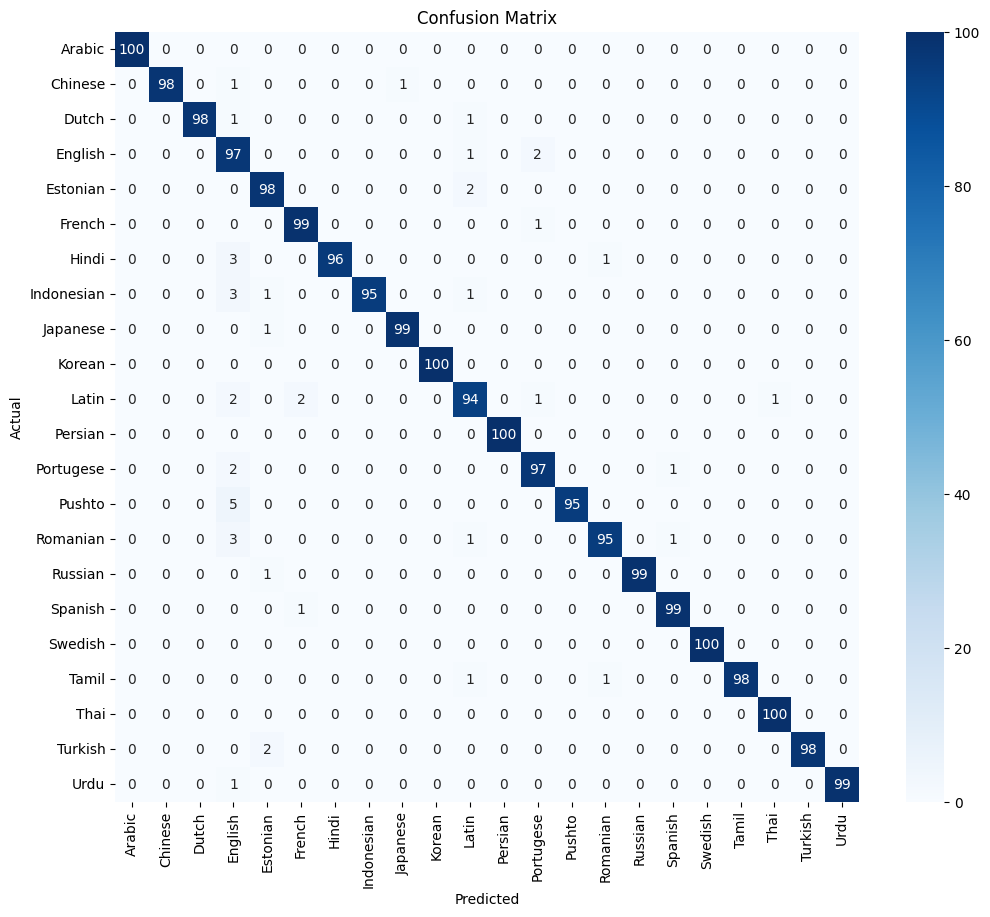

In [ ]:
# 6. Evaluation on Test Set
print("Loading best model for testing...")
model_save_path = '/home/zyk/Language Identification/models/best_lstm_model.pt'
model.load_state_dict(torch.load(model_save_path))

def get_predictions(model, iterator, device):
    model.eval()
    all_logits = []
    all_labels = []
    
    with torch.no_grad():
        for texts, labels, lengths in iterator:
            texts = texts.to(device)
            
            predictions = model(texts, lengths)
            all_logits.append(predictions)
            all_labels.append(labels)
            
    return torch.cat(all_logits, dim=0), torch.cat(all_labels, dim=0)

logits_tensor, y_true_tensor = get_predictions(model, test_loader, Config.device)
logits = logits_tensor.cpu().numpy()
y_true = y_true_tensor.cpu().numpy()
y_pred = np.argmax(logits, axis=1)

# Metrics
acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average='macro')

print(f'Test Accuracy: {acc:.4f}')
print(f'Macro-F1: {macro_f1:.4f}')
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=preprocessor.label_encoder.classes_, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=preprocessor.label_encoder.classes_,
            yticklabels=preprocessor.label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Training Dynamics Visualization
#### Loss Curves (Train vs Validation)
#### Accuracy / F1 Curves (Validation)

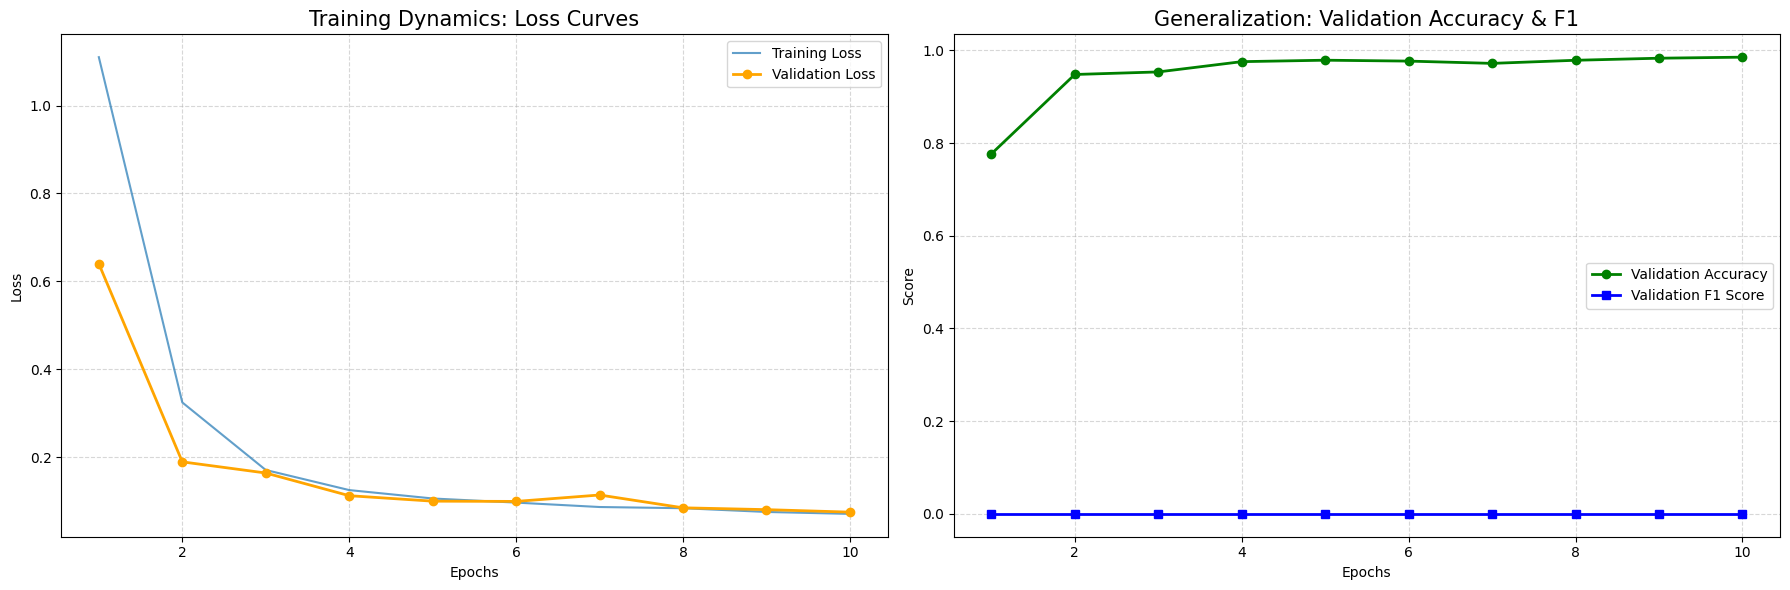

Training finished after 10 epochs.
Training completed all 10 epochs.
=== MSP Calibration Curve ===


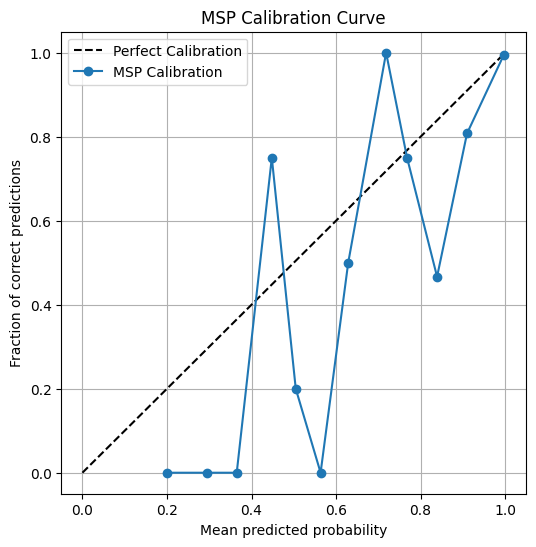

=== Top-5 Calibration Curves ===


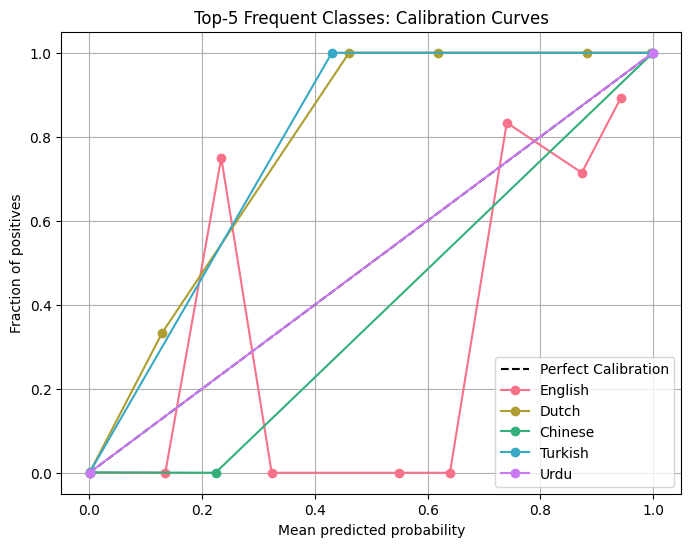

=== ECE Calculation ===
ECE = 0.0104


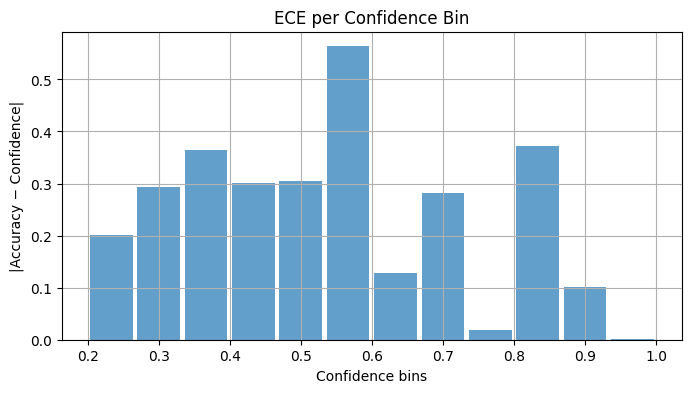

In [8]:
# Plot training history
if 'history' in locals() and history:
    plot_training_history(history, Config.num_epochs)
else:
    print("Training history not found. Please run the training cell first.")

# Calibration Analysis
# Convert logits → probabilities
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()
class_names = preprocessor.label_encoder.classes_

print("=== MSP Calibration Curve ===")
plot_msp_calibration(probs, y_pred, y_true)

print("=== Top-5 Calibration Curves ===")
plot_top5_calibration(probs, y_true, class_names, top_k=5)

print("=== ECE Calculation ===")
ece, bins, bin_accs, bin_confs, bin_sizes = compute_ece(probs, y_pred, y_true)
print(f"ECE = {ece:.4f}")

plot_ece_bar(bin_accs, bin_confs, bins)

## Latency Evaluation

In [9]:
# Prepare a single batch and a single sample
single_input, single_label = test_dataset[0]
single_input = single_input.unsqueeze(0).to(Config.device) # [1, seq_len]
single_length = torch.tensor([len(single_input[0])])

batch_input, batch_labels, batch_lengths = next(iter(test_loader))
batch_input = batch_input.to(Config.device) # [batch_size, seq_len]

def measure_latency(model, input_tensor, lengths, n_repeats=100, warmup=10):
    # Warmup
    for _ in range(warmup):
        with torch.no_grad():
            _ = model(input_tensor, lengths)
    
    if Config.device.type == 'cuda':
        torch.cuda.synchronize()
    
    start_time = time.time()
    for _ in range(n_repeats):
        with torch.no_grad():
            _ = model(input_tensor, lengths)
        if Config.device.type == 'cuda':
            torch.cuda.synchronize()
    end_time = time.time()
    
    avg_time = (end_time - start_time) / n_repeats
    return avg_time * 1000 # ms

print(f"{'Device':<10} | {'Type':<20} | {'Batch Size':<10} | {'Latency (ms)':<20} | {'Throughput (samples/s)':<25}")
print("-" * 95)

# Single sample
latency_ms = measure_latency(model, single_input, single_length)
throughput = 1000 / latency_ms
print(f"{str(Config.device):<10} | {'Single-sample':<20} | {1:<10} | {latency_ms:.2f}        | {throughput:.2f}")

# Batch
latency_ms = measure_latency(model, batch_input, batch_lengths)
throughput = (1000 / latency_ms) * Config.batch_size
print(f"{str(Config.device):<10} | {'Batch':<20} | {Config.batch_size:<10} | {latency_ms:.2f}        | {throughput:.2f}")

Device     | Type                 | Batch Size | Latency (ms)         | Throughput (samples/s)   
-----------------------------------------------------------------------------------------------


cuda       | Single-sample        | 1          | 10.86        | 92.08
cuda       | Batch                | 64         | 13.84        | 4624.82


# Model Internal Structure Visualization

This section visualizes the internal representations (embeddings) learned by the model.
We extract the context vector (output of attention mechanism) for the test set and project them into 2D space using PCA and t-SNE.
This demonstrates:
- The geometric structure of language families.
- Clustering of character patterns.
- Natural distances between categories.

Extracting embeddings from the test set...
Applying PCA...
Applying t-SNE...


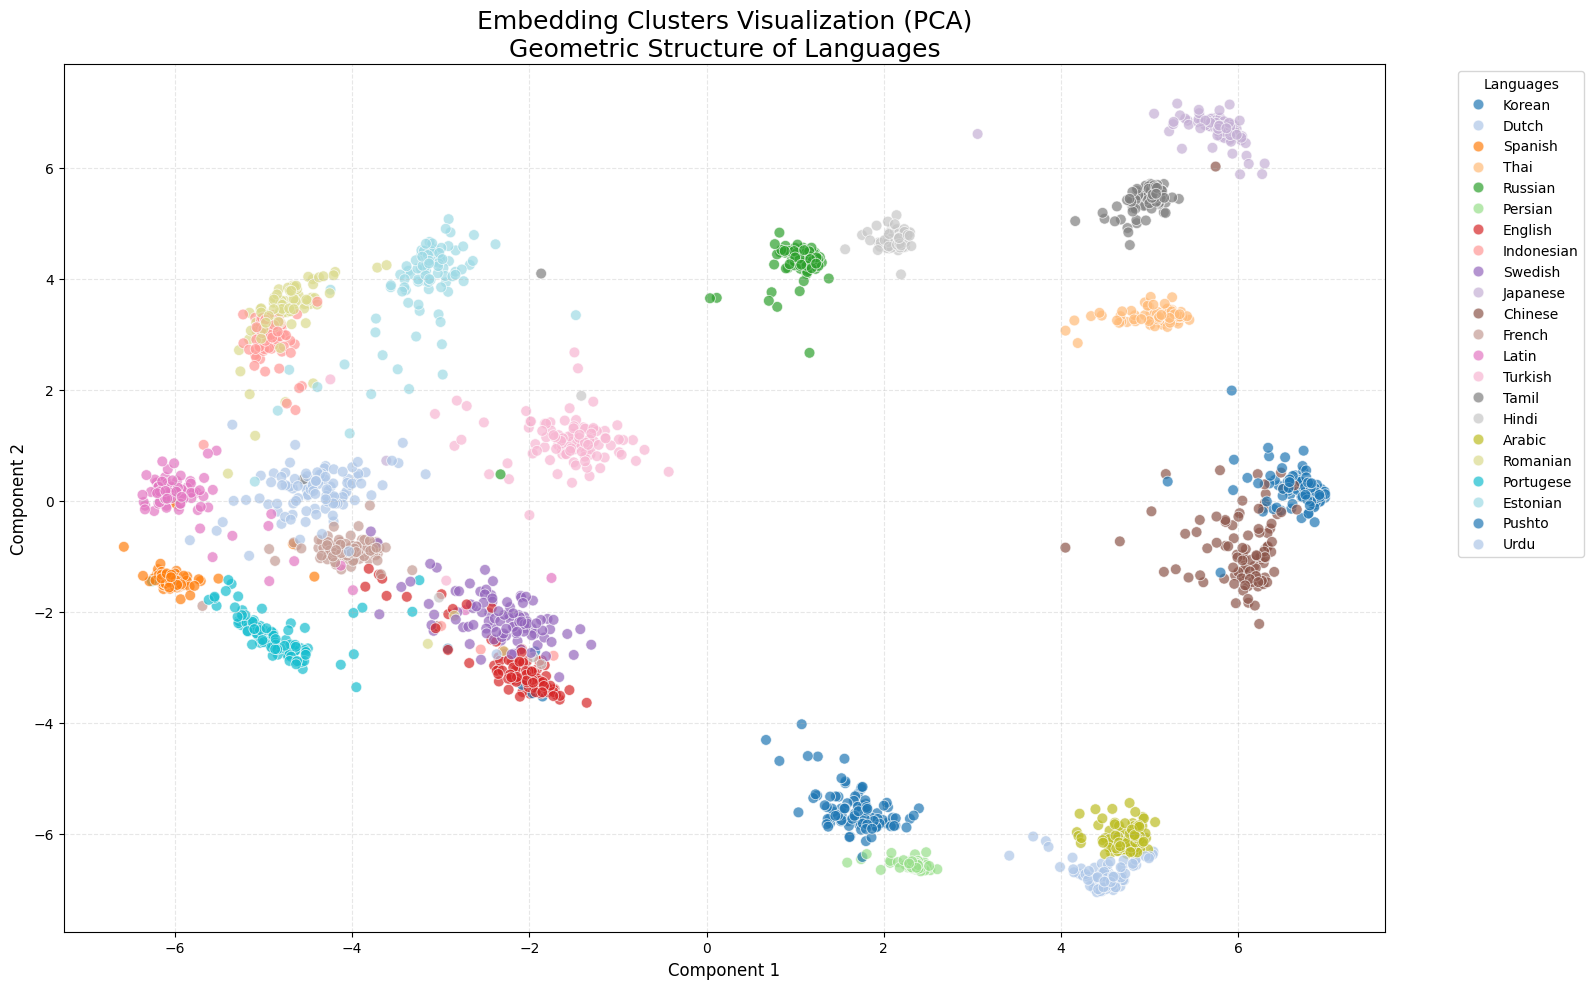

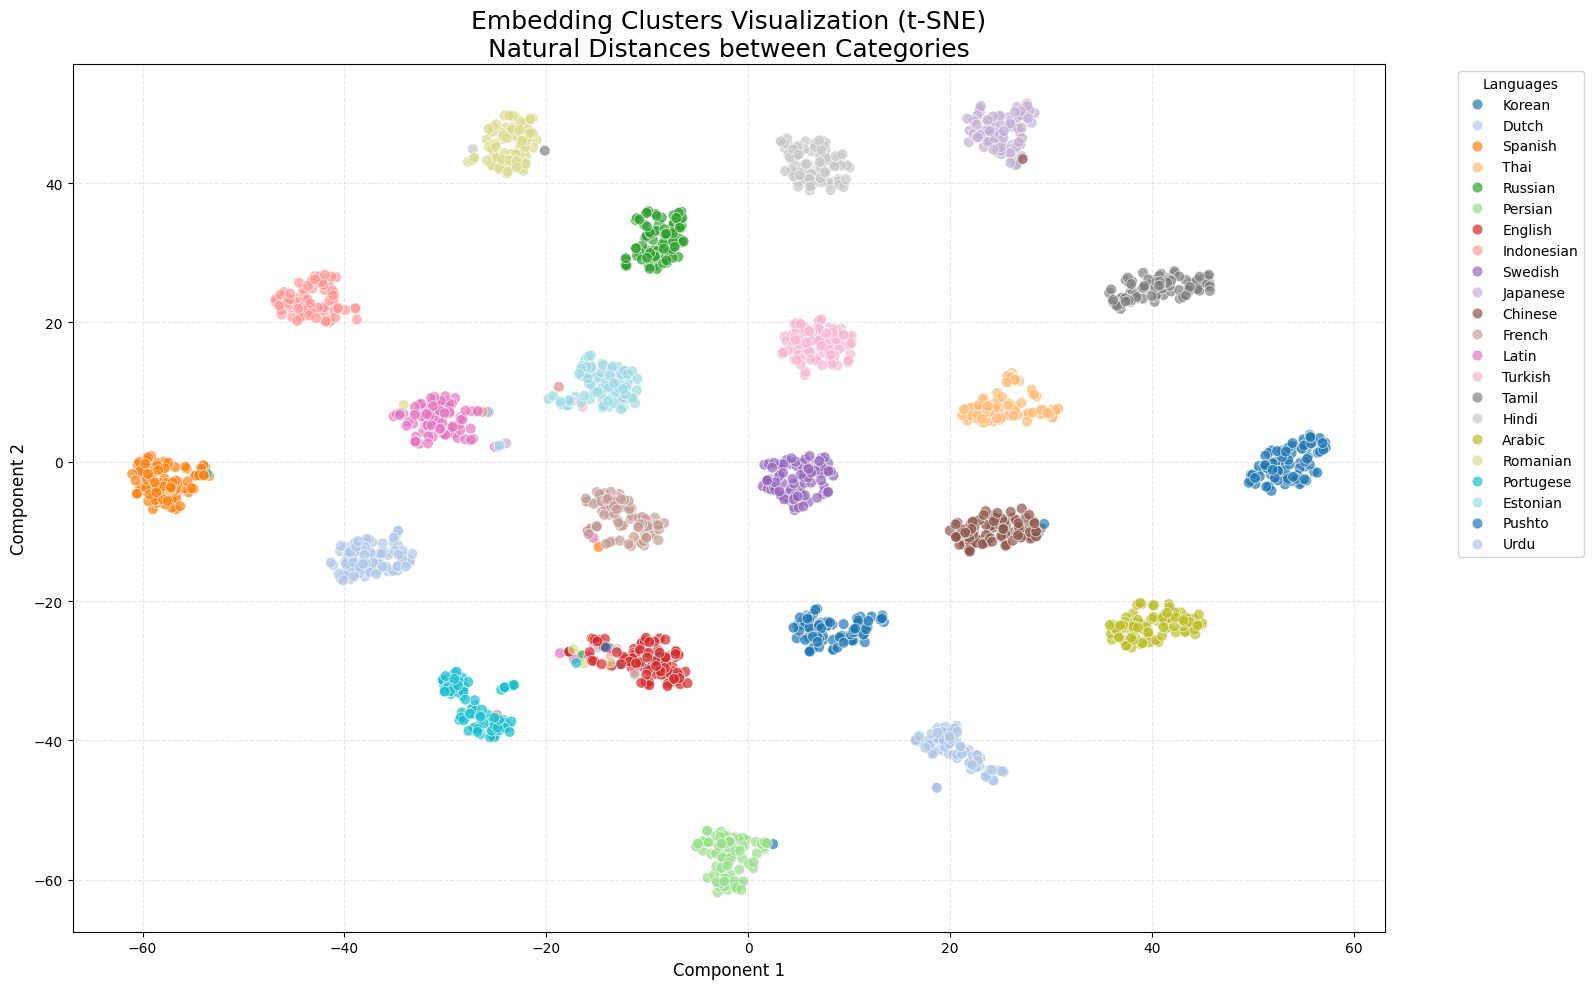

In [10]:
def get_embeddings_bilstm(model, iterator, device):
    model.eval()
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for texts, labels, lengths in iterator:
            texts = texts.to(device)
            # Use the new extract_features method
            embeddings = model.extract_features(texts, lengths)
            all_embeddings.append(embeddings.cpu().numpy())
            all_labels.append(labels.numpy())
            
    return np.concatenate(all_embeddings), np.concatenate(all_labels)

print("Extracting embeddings from the test set...")
embeddings, labels = get_embeddings_bilstm(model, test_loader, Config.device)

print("Applying PCA...")
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_tsne = tsne.fit_transform(embeddings)

plot_embeddings(embeddings_pca, labels, "Embedding Clusters Visualization (PCA)\nGeometric Structure of Languages", class_names)

plot_embeddings(embeddings_tsne, labels, "Embedding Clusters Visualization (t-SNE)\nNatural Distances between Categories", class_names)